In [1]:
!git clone https://github.com/davda54/sam

fatal: destination path 'sam' already exists and is not an empty directory.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time
from sam.sam import SAM

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [23]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
resume = True

if resume: 
    with open('sam_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [10]:
test_accuracy_history_sam

{(0.1, 0.001): [0.3938,
  0.566,
  0.6524,
  0.7316,
  0.7568,
  0.7942,
  0.768,
  0.7822,
  0.78,
  0.7834,
  0.8008,
  0.7972,
  0.8106,
  0.7964,
  0.8124,
  0.8116,
  0.8116,
  0.8124,
  0.8152,
  0.7998],
 (0.1, 0.0003): [0.405,
  0.5018,
  0.6206,
  0.6714,
  0.7056,
  0.7512,
  0.7562,
  0.7886,
  0.7956,
  0.8,
  0.8138,
  0.8084,
  0.8132,
  0.8174,
  0.8104,
  0.8176,
  0.8152,
  0.8122,
  0.83,
  0.8146],
 (0.1, 0.0001): [0.3984,
  0.4998,
  0.5774,
  0.636,
  0.707,
  0.7538,
  0.761,
  0.778,
  0.7844,
  0.7888,
  0.7952,
  0.794,
  0.7918,
  0.8048,
  0.8008,
  0.809,
  0.8064,
  0.8102,
  0.8082,
  0.8124],
 (0.1, 0): [0.3874,
  0.5266,
  0.618,
  0.6806,
  0.7256,
  0.747,
  0.7426,
  0.774,
  0.778,
  0.7866,
  0.7924,
  0.794,
  0.7956,
  0.7948,
  0.8042,
  0.8042,
  0.7974,
  0.8086,
  0.8072,
  0.805],
 (0.03, 0.001): [0.5592,
  0.706,
  0.7574,
  0.7856,
  0.8008,
  0.8234,
  0.8302,
  0.8378,
  0.8274,
  0.8454,
  0.838,
  0.8454,
  0.853,
  0.8394,
  0.8482,
  

In [11]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    base_optimizer = torch.optim.SGD
    optimizer = SAM(lenet.parameters(), base_optimizer, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    
    test_loss_history_sam[key] = list()
    test_accuracy_history_sam[key] = list()
    loss_in_training_sam[key] = list()
    time_learning_sam[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            # optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.first_step(zero_grad=True)
            
            preds_2 = lenet.forward(X_batch)
            loss_value_2 = loss(preds_2, y_batch)
            loss_value_2.backward()
            optimizer.second_step(zero_grad=True)
            sum_los += float(loss_value_2)
            
        time_learning_sam[key].append(time.time() - start_time)
        loss_in_training_sam[key].append(sum_los/450)
        print(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value               
        
        test_loss_history_sam[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_sam[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_sam[(learning_rate, weight_decay)])
    print(loss_in_training_sam[(learning_rate, weight_decay)])
    with open('drive/MyDrive/diplom/big/sam_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [12]:
for learning_rate in [0.1, 0.5, 1, 2]:
    key = 'schedule_' + str(learning_rate)
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    base_optimizer = torch.optim.SGD
    optimizer = SAM(lenet.parameters(), base_optimizer, rho=0.1, lr=learning_rate, momentum=0.9, weight_decay=0.0003)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    test_loss_history_sam[key] = list()
    test_accuracy_history_sam[key] = list()
    loss_in_training_sam[key] = list()
    time_learning_sam[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            # optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.first_step(zero_grad=True)
            
            preds_2 = lenet.forward(X_batch)
            loss_value_2 = loss(preds_2, y_batch)
            loss_value_2.backward()
            optimizer.second_step(zero_grad=True)
            sum_los += float(loss_value_2)
        
        scheduler.step()
        time_learning_sam[key].append(time.time() - start_time)
        loss_in_training_sam[key].append(sum_los/450)
        print(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value               
        
        test_loss_history_sam[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_sam[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_sam[key])
    print(loss_in_training_sam[key])
    with open('sam_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [13]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

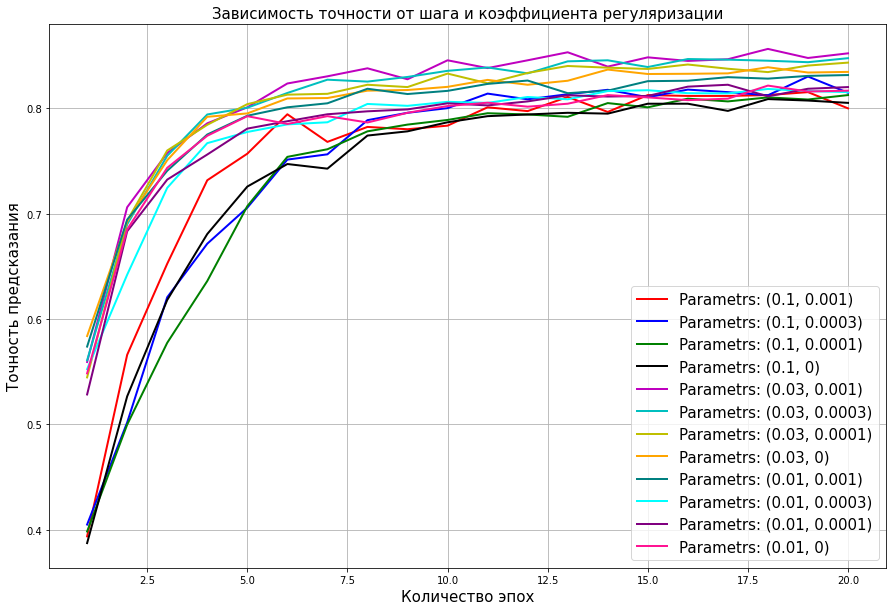

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
# plt.savefig('sgd_1_accrucy.png')

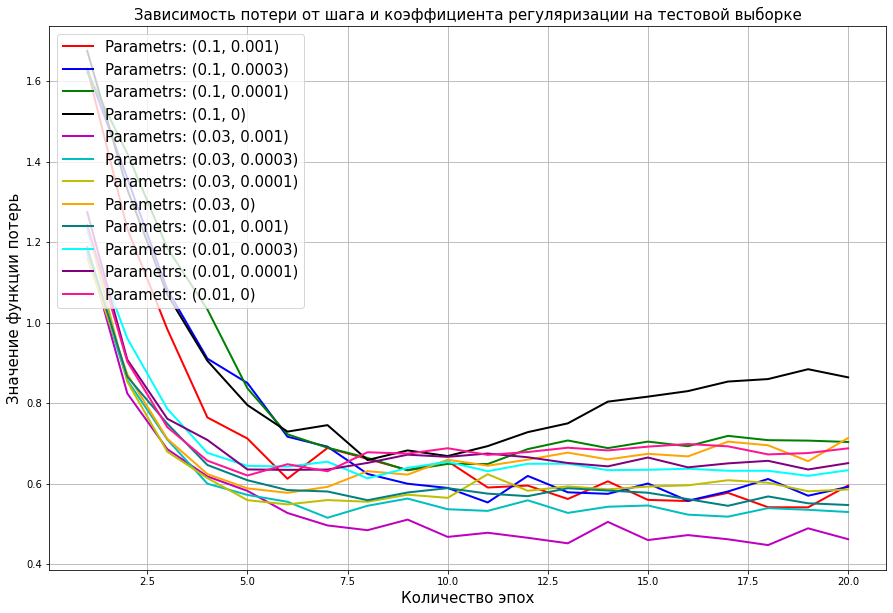

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

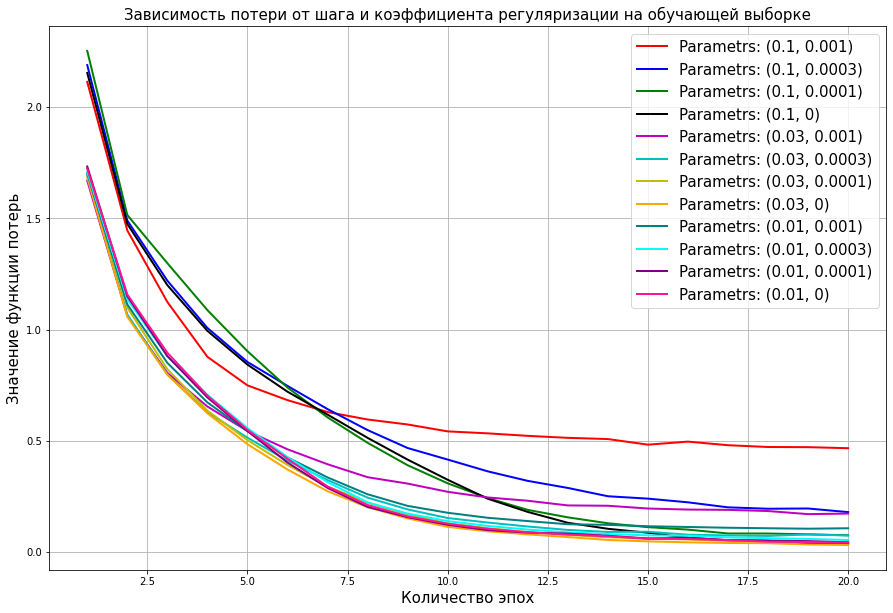

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

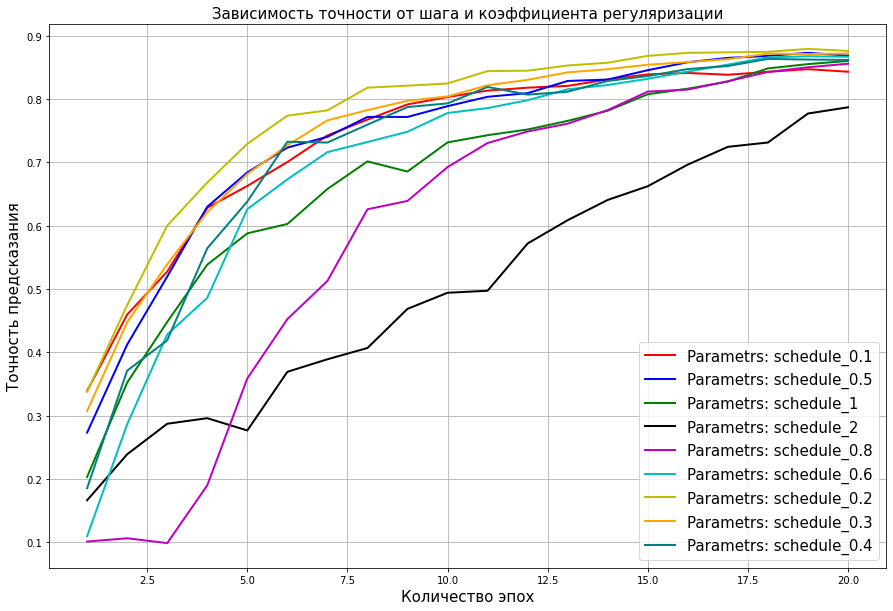

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    if param[0] == 's':
        plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15)
plt.grid(True)

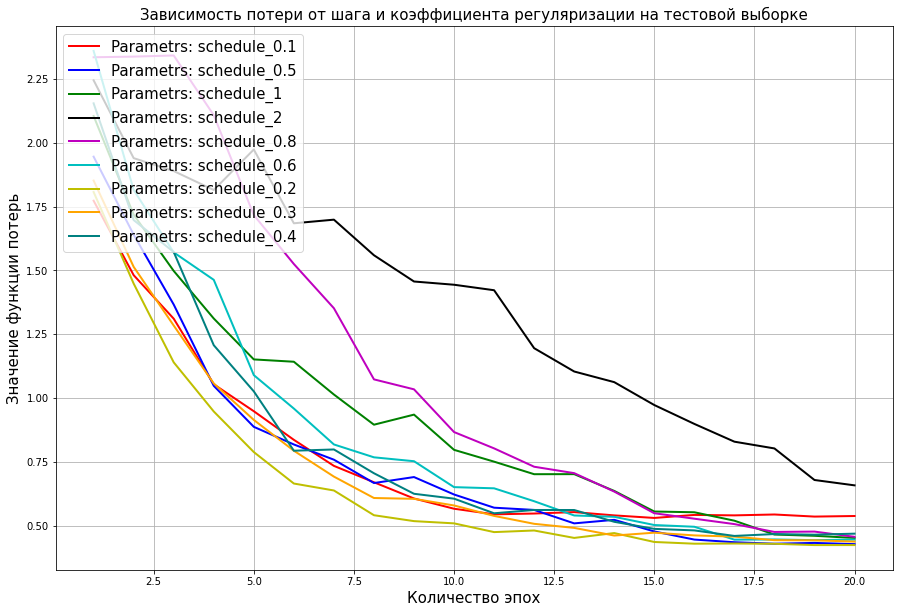

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    if param[0] == 's':
        plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

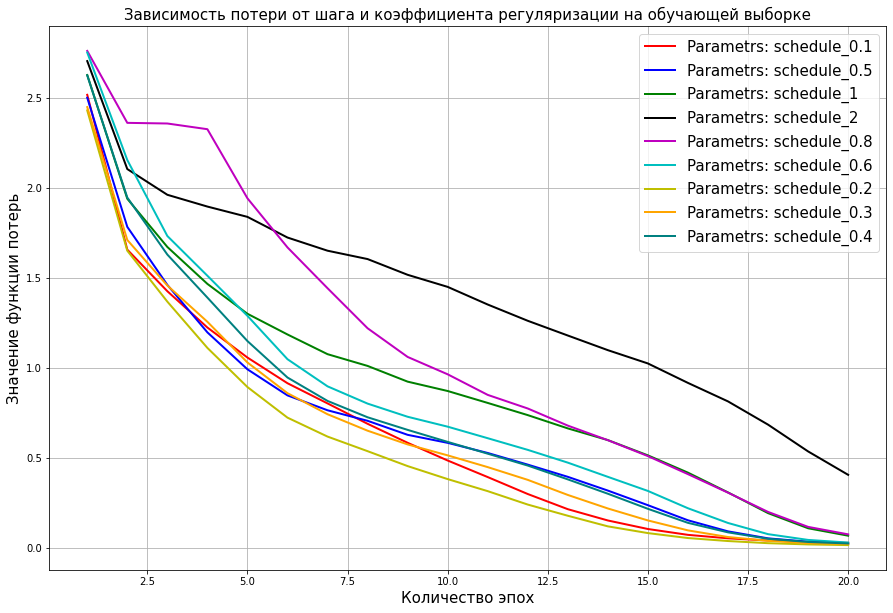

In [16]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    if param[0] == 's':
        plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [27]:
import tqdm
resume = True

if resume: 
    with open('drive/MyDrive/diplom/big/sam_rho_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sam = arr["acc"]
        test_loss_history_sam = arr["loss"]
        loss_in_training_sam = arr["loss_train"]
        time_learning_sam = arr["time"]
else:
    test_accuracy_history_sam, test_loss_history_sam, loss_in_training_sam, time_learning_sam = {}, {}, {}, {}

In [7]:
import tqdm

In [28]:
for p in tqdm.tqdm([0.01, 0.02, 0.05, 0.1, 0.2, 0.5]):
    key = p
    if key in test_accuracy_history_sam:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    base_optimizer = torch.optim.SGD
    optimizer = SAM(lenet.parameters(), base_optimizer, rho=p, lr=0.03, momentum=0.9, weight_decay=0.0003)
    
    test_loss_history_sam[key] = list()
    test_accuracy_history_sam[key] = list()
    loss_in_training_sam[key] = list()
    time_learning_sam[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            # optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch) 
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.first_step(zero_grad=True)
            
            preds_2 = lenet.forward(X_batch)
            loss_value_2 = loss(preds_2, y_batch)
            loss_value_2.backward()
            optimizer.second_step(zero_grad=True)
            sum_los += float(loss_value_2)
            
        time_learning_sam[key].append(time.time() - start_time)
        loss_in_training_sam[key].append(sum_los/450)
        print(sum_los/450)
            
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value               
        
        test_loss_history_sam[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
    
        test_accuracy_history_sam[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
    
    print(test_accuracy_history_sam[key])
    print(loss_in_training_sam[key])
    with open('drive/MyDrive/diplom/big/sam_rho_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

100%|██████████| 6/6 [00:00<00:00, 2149.46it/s]

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


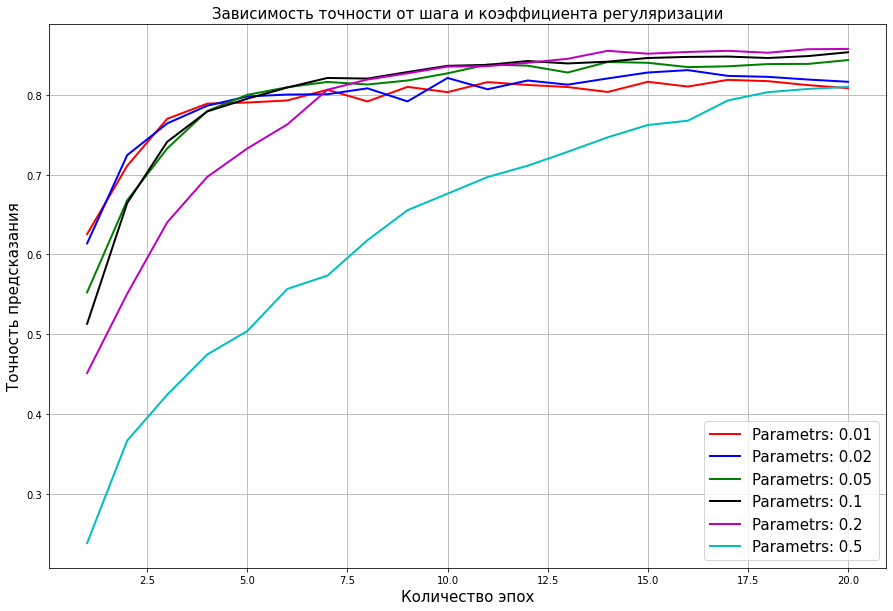

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sam.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
# plt.savefig('sgd_1_accrucy.png')

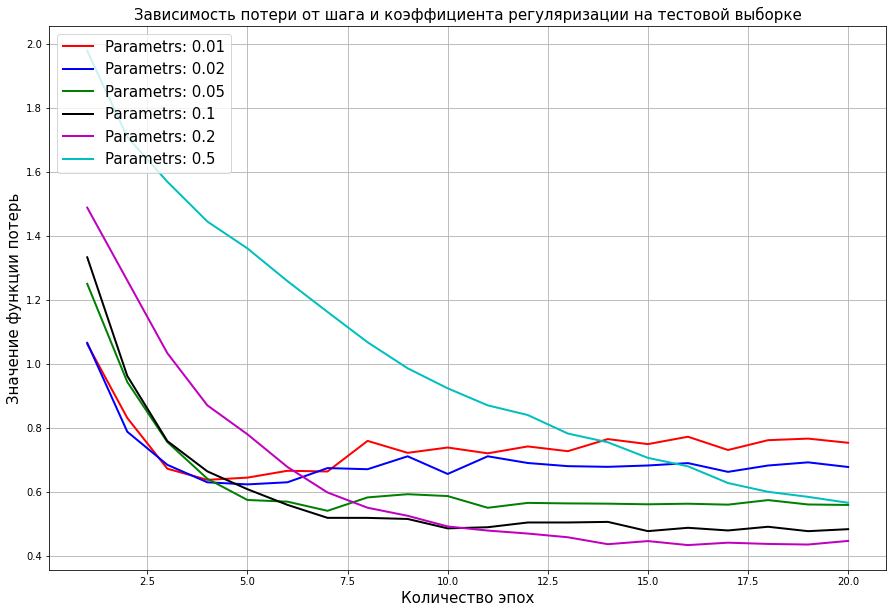

In [30]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sam.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

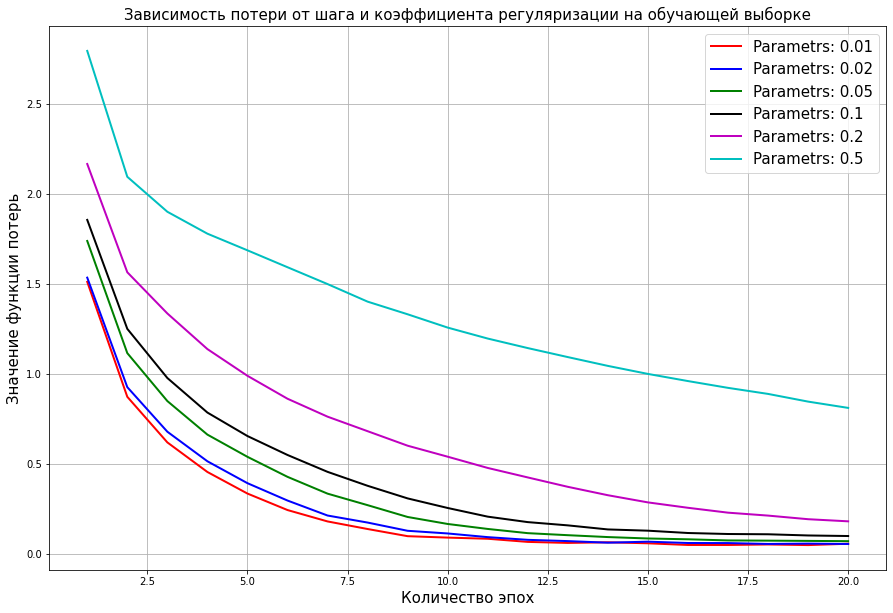

In [31]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sam.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [8]:
import tqdm

In [9]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

base_optimizer = torch.optim.SGD
optimizer = SAM(lenet.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0003)
    

test_loss_history_sam = list()
test_accuracy_history_sam = list()
loss_in_training_sam = list()
time_learning_sam = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        #optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.first_step(zero_grad=True)
        
        preds_2 = lenet.forward(X_batch)
        loss_value_2 = loss(preds_2, y_batch)
        loss_value_2.backward()
        optimizer.second_step(zero_grad=True)
        sum_los += float(loss_value_2)
        
    time_learning_sam.append(time.time() - start_time)
    loss_in_training_sam.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sam.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sam.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sam)
print(loss_in_training_sam)
with open('sam_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

  5%|▌         | 1/20 [00:39<12:23, 39.11s/it]

los epoch 0 : tensor(1.3039, device='cuda:0')
accuracy epoch 0 : 0.5299


 10%|█         | 2/20 [01:16<11:20, 37.83s/it]

los epoch 1 : tensor(0.9832, device='cuda:0')
accuracy epoch 1 : 0.6448


 15%|█▌        | 3/20 [01:53<10:37, 37.50s/it]

los epoch 2 : tensor(0.8109, device='cuda:0')
accuracy epoch 2 : 0.7132


 20%|██        | 4/20 [02:30<09:58, 37.41s/it]

los epoch 3 : tensor(0.6785, device='cuda:0')
accuracy epoch 3 : 0.7633


 25%|██▌       | 5/20 [03:07<09:20, 37.38s/it]

los epoch 4 : tensor(0.6019, device='cuda:0')
accuracy epoch 4 : 0.7882


 30%|███       | 6/20 [03:44<08:42, 37.33s/it]

los epoch 5 : tensor(0.5639, device='cuda:0')
accuracy epoch 5 : 0.8089


 35%|███▌      | 7/20 [04:22<08:05, 37.33s/it]

los epoch 6 : tensor(0.5417, device='cuda:0')
accuracy epoch 6 : 0.8123


 40%|████      | 8/20 [04:59<07:27, 37.33s/it]

los epoch 7 : tensor(0.5151, device='cuda:0')
accuracy epoch 7 : 0.8247


 45%|████▌     | 9/20 [05:37<06:50, 37.36s/it]

los epoch 8 : tensor(0.5010, device='cuda:0')
accuracy epoch 8 : 0.8326


 50%|█████     | 10/20 [06:14<06:13, 37.35s/it]

los epoch 9 : tensor(0.5128, device='cuda:0')
accuracy epoch 9 : 0.8307


 55%|█████▌    | 11/20 [06:51<05:35, 37.30s/it]

los epoch 10 : tensor(0.5061, device='cuda:0')
accuracy epoch 10 : 0.8332


 60%|██████    | 12/20 [07:28<04:58, 37.25s/it]

los epoch 11 : tensor(0.4932, device='cuda:0')
accuracy epoch 11 : 0.8413


 65%|██████▌   | 13/20 [08:05<04:20, 37.24s/it]

los epoch 12 : tensor(0.5049, device='cuda:0')
accuracy epoch 12 : 0.8397


 70%|███████   | 14/20 [08:43<03:43, 37.25s/it]

los epoch 13 : tensor(0.4907, device='cuda:0')
accuracy epoch 13 : 0.8441


 75%|███████▌  | 15/20 [09:20<03:06, 37.24s/it]

los epoch 14 : tensor(0.5038, device='cuda:0')
accuracy epoch 14 : 0.8427


 80%|████████  | 16/20 [09:57<02:29, 37.26s/it]

los epoch 15 : tensor(0.4927, device='cuda:0')
accuracy epoch 15 : 0.8426


 85%|████████▌ | 17/20 [10:35<01:51, 37.29s/it]

los epoch 16 : tensor(0.4922, device='cuda:0')
accuracy epoch 16 : 0.8487


 90%|█████████ | 18/20 [11:12<01:14, 37.26s/it]

los epoch 17 : tensor(0.4814, device='cuda:0')
accuracy epoch 17 : 0.8481


 95%|█████████▌| 19/20 [11:49<00:37, 37.26s/it]

los epoch 18 : tensor(0.4895, device='cuda:0')
accuracy epoch 18 : 0.8459


100%|██████████| 20/20 [12:26<00:00, 37.34s/it]

los epoch 19 : tensor(0.4931, device='cuda:0')
accuracy epoch 19 : 0.8488
[0.5299, 0.6448, 0.7132, 0.7633, 0.7882, 0.8089, 0.8123, 0.8247, 0.8326, 0.8307, 0.8332, 0.8413, 0.8397, 0.8441, 0.8427, 0.8426, 0.8487, 0.8481, 0.8459, 0.8488]
[1.8627834084241286, 1.2547120098186575, 0.9898940247038136, 0.8207175903994104, 0.6807796188670656, 0.5764407720902692, 0.4867893445103065, 0.40632310104758845, 0.33352322769553766, 0.27941439419013003, 0.22947851639726888, 0.19260578568538894, 0.1694273203611374, 0.15406456511953603, 0.13420811736065408, 0.1260734971612692, 0.11578884838229936, 0.11048351878543262, 0.10475117049139479, 0.10455025406149418]


In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [12]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

base_optimizer = torch.optim.SGD
optimizer = SAM(lenet.parameters(), base_optimizer, rho=0.1, lr=0.03, momentum=0.9, weight_decay=0.0003)
    

test_loss_history_sam = list()
test_accuracy_history_sam = list()
loss_in_training_sam = list()
time_learning_sam = list()

test_accuracy = 0

while test_accuracy <= 0.75:

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        #optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.first_step(zero_grad=True)
        
        preds_2 = lenet.forward(X_batch)
        loss_value_2 = loss(preds_2, y_batch)
        loss_value_2.backward()
        optimizer.second_step(zero_grad=True)
        sum_los += float(loss_value_2)
        
    time_learning_sam.append(time.time() - start_time)
    loss_in_training_sam.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sam.append(los/100)
    print('los epoch:', los/100)
    
    test_accuracy = correct/total
    test_accuracy_history_sam.append(test_accuracy)
    print('accuracy epoch:', test_accuracy)

print(test_accuracy_history_sam)
print(loss_in_training_sam)
with open('sam_bresults_75.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

los epoch: tensor(1.3057, device='cuda:0')
accuracy epoch: 0.5289
los epoch: tensor(0.9895, device='cuda:0')
accuracy epoch: 0.6466
los epoch: tensor(0.8255, device='cuda:0')
accuracy epoch: 0.7056
los epoch: tensor(0.6510, device='cuda:0')
accuracy epoch: 0.7735
[0.5289, 0.6466, 0.7056, 0.7735]
[1.8631088531535605, 1.2548843943554422, 0.9840357681979304, 0.8006315068058346]


In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [15]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

base_optimizer = torch.optim.SGD
optimizer = SAM(lenet.parameters(), base_optimizer, rho=0.1, lr=0.2, momentum=0.9, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    

test_loss_history_sam = list()
test_accuracy_history_sam = list()
loss_in_training_sam = list()
time_learning_sam = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        #optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.first_step(zero_grad=True)
        
        preds_2 = lenet.forward(X_batch)
        loss_value_2 = loss(preds_2, y_batch)
        loss_value_2.backward()
        optimizer.second_step(zero_grad=True)
        sum_los += float(loss_value_2)
        
    scheduler.step()
    time_learning_sam.append(time.time() - start_time)
    loss_in_training_sam.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sam.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sam.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sam)
print(loss_in_training_sam)
with open('sam_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sam, "loss": test_loss_history_sam, "loss_train":loss_in_training_sam, "time":time_learning_sam}, f)

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  5%|▌         | 1/20 [00:36<11:37, 36.73s/it]

los epoch 0 : tensor(1.8190, device='cuda:0')
accuracy epoch 0 : 0.3251


 10%|█         | 2/20 [01:13<11:05, 36.94s/it]

los epoch 1 : tensor(1.5692, device='cuda:0')
accuracy epoch 1 : 0.4005


 15%|█▌        | 3/20 [01:51<10:30, 37.09s/it]

los epoch 2 : tensor(1.3575, device='cuda:0')
accuracy epoch 2 : 0.5032


 20%|██        | 4/20 [02:28<09:55, 37.21s/it]

los epoch 3 : tensor(1.0523, device='cuda:0')
accuracy epoch 3 : 0.6245


 25%|██▌       | 5/20 [03:05<09:18, 37.24s/it]

los epoch 4 : tensor(0.8822, device='cuda:0')
accuracy epoch 4 : 0.6897


 30%|███       | 6/20 [03:42<08:41, 37.22s/it]

los epoch 5 : tensor(0.7857, device='cuda:0')
accuracy epoch 5 : 0.7197


 35%|███▌      | 7/20 [04:20<08:03, 37.23s/it]

los epoch 6 : tensor(0.6470, device='cuda:0')
accuracy epoch 6 : 0.7745


 40%|████      | 8/20 [04:57<07:26, 37.24s/it]

los epoch 7 : tensor(0.6258, device='cuda:0')
accuracy epoch 7 : 0.786


 45%|████▌     | 9/20 [05:34<06:50, 37.28s/it]

los epoch 8 : tensor(0.5476, device='cuda:0')
accuracy epoch 8 : 0.8104


 50%|█████     | 10/20 [06:12<06:12, 37.28s/it]

los epoch 9 : tensor(0.5471, device='cuda:0')
accuracy epoch 9 : 0.8116


 55%|█████▌    | 11/20 [06:49<05:35, 37.26s/it]

los epoch 10 : tensor(0.4955, device='cuda:0')
accuracy epoch 10 : 0.8296


 60%|██████    | 12/20 [07:26<04:58, 37.27s/it]

los epoch 11 : tensor(0.4753, device='cuda:0')
accuracy epoch 11 : 0.8405


 65%|██████▌   | 13/20 [08:03<04:20, 37.23s/it]

los epoch 12 : tensor(0.4683, device='cuda:0')
accuracy epoch 12 : 0.844


 70%|███████   | 14/20 [08:40<03:43, 37.22s/it]

los epoch 13 : tensor(0.4776, device='cuda:0')
accuracy epoch 13 : 0.8481


 75%|███████▌  | 15/20 [09:18<03:06, 37.20s/it]

los epoch 14 : tensor(0.4428, device='cuda:0')
accuracy epoch 14 : 0.8616


 80%|████████  | 16/20 [09:55<02:28, 37.21s/it]

los epoch 15 : tensor(0.4344, device='cuda:0')
accuracy epoch 15 : 0.8674


 85%|████████▌ | 17/20 [10:32<01:51, 37.18s/it]

los epoch 16 : tensor(0.4349, device='cuda:0')
accuracy epoch 16 : 0.8703


 90%|█████████ | 18/20 [11:09<01:14, 37.20s/it]

los epoch 17 : tensor(0.4335, device='cuda:0')
accuracy epoch 17 : 0.8719


 95%|█████████▌| 19/20 [11:46<00:37, 37.22s/it]

los epoch 18 : tensor(0.4350, device='cuda:0')
accuracy epoch 18 : 0.8721


100%|██████████| 20/20 [12:24<00:00, 37.21s/it]

los epoch 19 : tensor(0.4349, device='cuda:0')
accuracy epoch 19 : 0.8744
[0.3251, 0.4005, 0.5032, 0.6245, 0.6897, 0.7197, 0.7745, 0.786, 0.8104, 0.8116, 0.8296, 0.8405, 0.844, 0.8481, 0.8616, 0.8674, 0.8703, 0.8719, 0.8721, 0.8744]
[2.498222501122433, 1.7638383670993474, 1.534071941997694, 1.2569865069959474, 1.011455020956371, 0.8430548086762428, 0.7090818817200868, 0.6146133039308631, 0.531833732192931, 0.45815540001444194, 0.3870867676385071, 0.3093135483239008, 0.23981952581392682, 0.17449872965074104, 0.11844089217483997, 0.07988990106336448, 0.056060465692502004, 0.03832468452620442, 0.029588960696254735, 0.023943345913784983]


In [7]:
test_accuracy_history_sam

[0.515, 0.6405, 0.7289, 0.7805]